# Chess - predict winner based on the first K moves

## The goal of our project is to predict the outcome of chess games based on the first K moves.
## The database is taken from online chess games

Import Python Libraries

In [663]:
#data processing
import pickle

import pandas as pd
import numpy as np
import torch
from tqdm import tqdm

#data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Machine learning library
import sklearn
from sklearn.model_selection import train_test_split

#chess related
!pip install python-chess
import chess
import chess.pgn
import io

np.random.seed(7)

You should consider upgrading via the '/Users/guyhaimovitz/PycharmProjects/chess/venv/bin/python -m pip install --upgrade pip' command.


Reading Chess Dataset
The dataset columns : [Game_id, PGN, Mode, Result, Average Rating, Rating difference, Termination type]
PGN - A formatted game moves - [[move_ordinal, white_move, black_move]

In [664]:
data = pd.read_csv("data/lichess-08-2014.csv")

In [665]:
data.head()

,Unnamed: 0,PGN,Mode,Result,Average Rating,Rating Difference,Termination Type
0,0,1. e4 g6 2. d4 Bg7 3. c3 d6 4. Qf3 Nf6 5. h3 O...,Classical,Black Wins,1538,-262,Time forfeit
1,1,1. d4 Nf6 2. c4 g6 3. a3 Bg7 4. Nf3 O-O 5. Nc3...,Blitz,Black Wins,1492,-220,Time forfeit
2,2,1. e4 c5 2. Qf3 e5 3. Bc4 Nf6 4. Nh3 h6 5. g4 ...,Blitz,White Wins,1413,213,Normal
3,3,1. e4 e5 2. Nf3 d6 3. Nc3 f5 4. exf5 Bxf5 5. d...,Blitz,Black Wins,1444,-358,Normal
4,4,1. e4 e6 2. d4 d5 3. Nc3 Nf6 4. e5 Ne4 5. Nce2...,Bullet,White Wins,1931,117,Normal


## First we’ll create a baseline model that will take as input only the 2 rating columns - the avg  of the 2 players rating and the difference of the rating, We'll see what accuracy we can get with this simple model.
## We want to predict only classic games that have ended with a win in a 'normal' way - no timeout and no draw

# First we will clean the data

Let's take only the classic games, remove draws and time wins

In [666]:
data = data[data["Mode"] =="Classical"]
data = data[data["Termination Type"] =="Normal"]
data = data[data.Result != 'Draw']
del data["Termination Type"], data['Mode'], data['Unnamed: 0']
data = data.reset_index(drop=True)
data.head()

,PGN,Result,Average Rating,Rating Difference
0,1. e4 e5 2. Nf3 Nf6 3. d3 Bc5 4. Be2 Nc6 5. c3...,Black Wins,1544,-208
1,1. e4 e5 2. f4 exf4 3. Nf3 Nc6 4. d4 Bb4+ 5. c...,White Wins,1353,-1
2,1. e4 e5 2. Nf3 Nc6 3. Bb5 Nd4 4. Nxe5 Nxb5 5....,White Wins,1561,-144
3,1. e4 d5 2. Nc3 d4 3. Nd5 e5 4. Nf3 f5 5. Nxe5...,White Wins,1246,155
4,1. d4 a6 2. e4 e6 3. e5 c5 4. c3 cxd4 5. Qxd4 ...,Black Wins,1381,-279


Our data does not contains empty values

In [667]:
data.isna().sum()

PGN                  0
Result               0
Average Rating       0
Rating Difference    0
dtype: int64

# Our model is taking games features for only the first k=20 moves
# For performance purposes we will limit the games

In [668]:
limit_moves = 20
limit_games = 500

# model training

Split to train & test

In [669]:
train_data, test_data = train_test_split(data.head(limit_games), test_size=0.3)

In [670]:
print(f'train data game results:\n{train_data["Result"].value_counts()}')
print(f'test data game results:\n{test_data["Result"].value_counts()}')

train data game results:
Black Wins    176
White Wins    174
Name: Result, dtype: int64
test data game results:
White Wins    84
Black Wins    66
Name: Result, dtype: int64


# As we can see the data is fairly balanced, so we don't need to deal with balancing the dataset

# Now we will train our baseline model using LogisticRegression on the available features - average rating and rating difference (avg rating of the two players and the difference)

In [671]:
from sklearn import linear_model, metrics, preprocessing
model = linear_model.LogisticRegression()

X_train = train_data[['Average Rating', 'Rating Difference']]
y_train = train_data['Result']

X_test = test_data[['Average Rating', 'Rating Difference']]
y_test = test_data['Result']

scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

model.fit(X_train, y_train)

predicted = model.predict(X_test)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

  Black Wins       0.62      0.68      0.65        66
  White Wins       0.73      0.67      0.70        84

    accuracy                           0.67       150
   macro avg       0.67      0.67      0.67       150
weighted avg       0.68      0.67      0.67       150



Now we've got our benchmark results, in the following cells will try to create a better model

# Feature extraction

## Next lets gather some informative game features
## We will calculate some features for each player:

1. Number of checks made
2. Number of possible checks (not actually made by the players)
3. Number of castling made
4. Average of possible moves after each move
5. Average of reachable squares after each move
6. Average of threatened pieces after each move
7. Average of pieces left after each move
8. Number of total moves (game length)

In [672]:
def extract_features(pgn, move_number = 5):

    pieces = {
        'p': 1, 'k': 0, 'q': 9, 'b': 3, 'r': 5, 'n': 3, None: 0
    }

    # Calculate how many pieces is left for both players in the game (represented with fen)
    def calc_pieces_left(fen):

        pos = fen.split()[0]
        white = sum([pieces[c] for c in pos if c in "pkqrbnp"])
        black = sum([pieces[c.lower()] for c in pos if c in "pkqrbnp".upper()])
        return black, white


    feat_df = pd.DataFrame(columns=['player', 'checks', 'avg_possible_checks', 'castling', 'avg_possible_moves', 'avg_reachable_squares', 'avg_threatened_pieces', 'avg_pieces_left'])

    pgn_io = io.StringIO(pgn)
    game = chess.pgn.read_game(pgn_io)
    board = chess.Board()

    checks = [0, 0]
    castling = [0, 0]
    possible_checks = [[], []]
    possible_moves = [[], []]
    reachable_squares = [[], []]
    threatened_pieces = [[], []]
    values = [[],[]]

    player = 0
    #p_dict = {0:'White', 1: 'Black'}
    # Go through each move in the game until
    # we reach the required move number
    for number, move in enumerate(game.mainline_moves()):

        # It copies the move played by each
        # player on the virtual board
        if board.is_castling(move):
            castling[player] += 1
            #feat_df[p_dict[player]]['castling'] += 1
        possible_moves_count = 0
        possible_checks_count = 0
        for possible_move in board.legal_moves:
            if board.gives_check(possible_move):
                possible_checks_count += 1
            possible_moves_count += 1

        possible_checks[player].append(possible_checks_count)
        possible_moves[player].append(possible_moves_count)

        reachable_squares_count = 0
        threatened_pieces_count = 0
        for i in range(64):
            if board.piece_at(i) is not None and board.is_attacked_by(player, i):
                if board.piece_at(i).color != player:
                    threatened_pieces_count += pieces[str(board.piece_at(i)).lower()]
            if board.is_attacked_by(player, i):
                reachable_squares_count += 1

        reachable_squares[player].append(reachable_squares_count)
        threatened_pieces[player].append(threatened_pieces_count)

        board.push(move)

        val_0, val_1 = calc_pieces_left(board.fen())
        values[0].append(val_0)
        values[1].append(val_1)
        if board.is_check():
            #feat_df[player]['checks'] += 1
            checks[player] += 1
        # Remember that number starts from 0
        if number == move_number:
            break

        player = 1 - player

    for i, p in enumerate(['White', 'Black']):

        feat_df.loc[i] = [p, checks[i], sum(possible_checks[i]) / (len(possible_checks[i]) + 1e-10), castling[i], sum(possible_moves[i]) / (len(possible_moves[i]) + 1e-10), sum(reachable_squares[i]) / (len(reachable_squares[i]) + 1e-10), sum(threatened_pieces[i]) / (len(threatened_pieces[i]) + 1e-10), sum(values[i]) / (len(values[i]) + 1e-10)]

    return feat_df

In [673]:
new_feat_cols = ['w_checks', 'w_avg_possible_checks', 'w_castling', 'w_avg_possible_moves', 'w_avg_reachable_squares', 'w_avg_threatened_pieces', 'w_avg_pieces_left', 'b_checks', 'b_avg_possible_checks', 'b_castling', 'b_avg_possible_moves', 'b_avg_reachable_squares', 'b_avg_threatened_pieces', 'b_avg_pieces_left']

feat_df = pd.DataFrame(columns=new_feat_cols)

for i, pgn in enumerate(data.PGN):
    game_features = extract_features(pgn, move_number=limit_moves)
    # print(f'{i+1}/{len(data)}')
    feat_df.loc[i] = game_features[game_features['player'] == 'White'].values[0][1:].tolist() + game_features[game_features['player'] == 'Black'].values[0][1:].tolist()
    if i == limit_games - 1:
        break

data_feat = data.loc[np.arange(0, limit_games)].join(feat_df)
data_feat.head()

,PGN,Result,Average Rating,Rating Difference,w_checks,w_avg_possible_checks,w_castling,w_avg_possible_moves,w_avg_reachable_squares,w_avg_threatened_pieces,w_avg_pieces_left,b_checks,b_avg_possible_checks,b_castling,b_avg_possible_moves,b_avg_reachable_squares,b_avg_threatened_pieces,b_avg_pieces_left
0,1. e4 e5 2. Nf3 Nf6 3. d3 Bc5 4. Be2 Nc6 5. c3...,Black Wins,1544,-208,0.0,0.090909,1.0,31.090909,33.545455,2.181818,38.333333,0.0,0.6,1.0,35.7,33.2,1.8,38.333333
1,1. e4 e5 2. f4 exf4 3. Nf3 Nc6 4. d4 Bb4+ 5. c...,White Wins,1353,-1,0.0,0.454545,0.0,25.909091,30.272727,2.272727,37.285714,3.0,1.3,0.0,29.7,34.7,2.4,37.761905
2,1. e4 e5 2. Nf3 Nc6 3. Bb5 Nd4 4. Nxe5 Nxb5 5....,White Wins,1561,-144,2.0,2.090909,1.0,33.363636,29.636364,2.000000,35.285714,0.0,0.4,0.0,27.6,33.0,3.9,36.380952
3,1. e4 d5 2. Nc3 d4 3. Nd5 e5 4. Nf3 f5 5. Nxe5...,White Wins,1246,155,1.0,2.000000,0.0,33.090909,34.181818,3.545455,37.285714,0.0,0.1,0.0,32.2,33.7,1.7,38.333333
4,1. d4 a6 2. e4 e6 3. e5 c5 4. c3 cxd4 5. Qxd4 ...,Black Wins,1381,-279,0.0,0.272727,0.0,35.272727,29.818182,2.454545,38.333333,0.0,0.4,0.0,31.9,35.3,1.6,38.380952


# Now that we have our new 'hand engineered' features lets plot some graphs

In [674]:
# Unmark if the csv file is needed
# data.to_csv('data/chess_features.csv')

# Exploring & Visualization

In [675]:
data_feat.describe()

,Average Rating,Rating Difference,w_checks,w_avg_possible_checks,w_castling,w_avg_possible_moves,w_avg_reachable_squares,w_avg_threatened_pieces,w_avg_pieces_left,b_checks,b_avg_possible_checks,b_castling,b_avg_possible_moves,b_avg_reachable_squares,b_avg_threatened_pieces,b_avg_pieces_left
count,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,1555.776000,10.174000,0.33600,0.532872,0.458000,32.222260,31.294837,2.254758,37.608620,0.262000,0.438941,0.328000,29.990188,33.386238,2.292995,37.598436
std,197.113626,193.175592,0.70149,0.480226,0.498732,3.877786,1.651772,1.068505,1.304813,0.605052,0.479574,0.469955,3.761805,1.731135,1.106156,1.385570
min,1028.000000,-565.000000,0.00000,0.000000,0.000000,18.909091,22.000000,0.000000,30.714286,0.000000,0.000000,0.000000,13.000000,28.300000,0.000000,29.904762
25%,1413.000000,-112.500000,0.00000,0.181818,0.000000,29.636364,30.181818,1.454545,37.000000,0.000000,0.000000,0.000000,27.787500,32.200000,1.500000,37.047619
50%,1553.000000,4.000000,0.00000,0.454545,0.000000,32.227273,31.363636,2.090909,37.883117,0.000000,0.300000,0.000000,30.000000,33.400000,2.200000,37.952381
75%,1701.000000,118.000000,0.00000,0.727273,1.000000,34.727273,32.454545,3.000000,38.428571,0.000000,0.700000,1.000000,32.400000,34.700000,3.000000,38.571429
max,2053.000000,653.000000,6.00000,3.818182,1.000000,43.909091,35.181818,5.727273,39.000000,3.000000,3.700000,1.000000,40.000000,37.600000,5.900000,39.000000


lest plot the rating histogram

<AxesSubplot:>

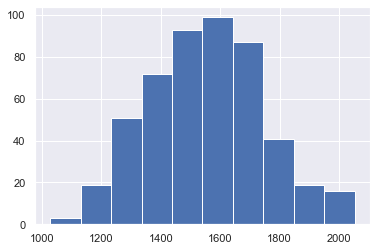

In [676]:
data_feat["Average Rating"].hist()

We can see that the average rating is around 1500 with a nice spread

Now we'll compare the features between black and white players

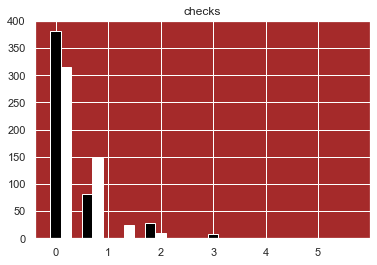

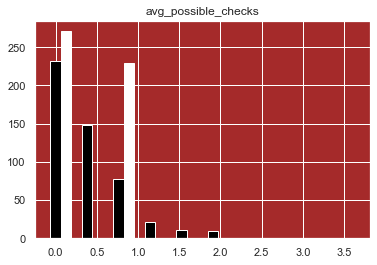

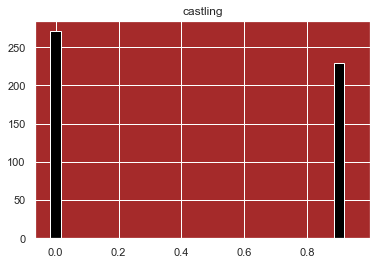

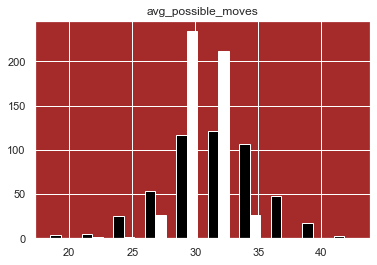

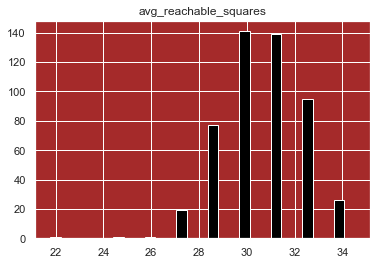

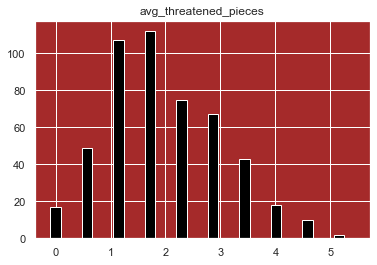

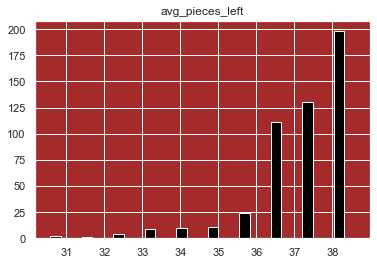

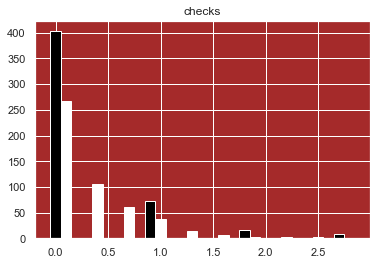

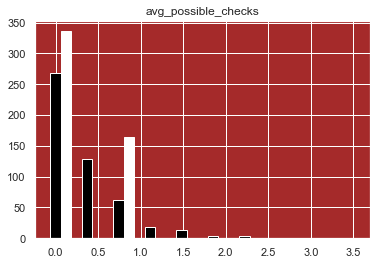

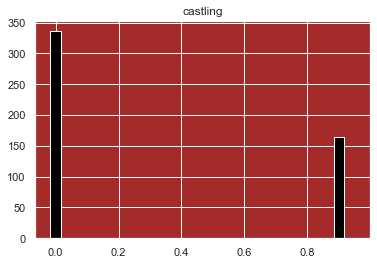

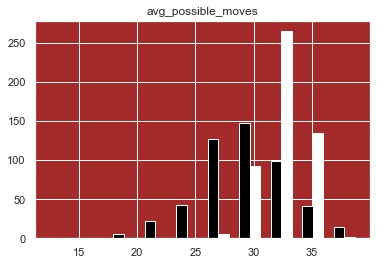

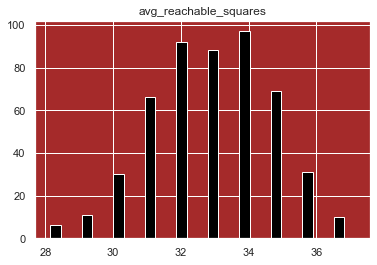

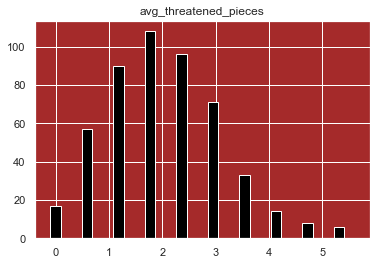

In [677]:
for i in range(len(new_feat_cols)-1):

    w_col = data_feat[new_feat_cols[i]]
    b_col = data_feat[new_feat_cols[i+1]]

    fig, ax = plt.subplots()
    fig.patch.set_facecolor('white')
    ax.set_facecolor('brown')
    ax.set_title(new_feat_cols[i][2:])
    a_heights, a_bins = np.histogram(w_col)
    b_heights, b_bins = np.histogram(b_col, bins=a_bins)

    width = (a_bins[1] - a_bins[0])/3

    ax.bar(a_bins[:-1], a_heights, width=width, facecolor='black')
    ax.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='white')


## Lets make sure our new data contains no empty values

In [678]:
data_feat.isna().sum()

PGN                        0
Result                     0
Average Rating             0
Rating Difference          0
w_checks                   0
w_avg_possible_checks      0
w_castling                 0
w_avg_possible_moves       0
w_avg_reachable_squares    0
w_avg_threatened_pieces    0
w_avg_pieces_left          0
b_checks                   0
b_avg_possible_checks      0
b_castling                 0
b_avg_possible_moves       0
b_avg_reachable_squares    0
b_avg_threatened_pieces    0
b_avg_pieces_left          0
dtype: int64

Lets make sure our features have a positive std

In [679]:
data_feat.std(numeric_only=None)

/var/folders/p1/tw7t1b3x6_v9kb__xp94dz_r0000gn/T/ipykernel_73847/1818227677.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data_feat.std(numeric_only=None)


Average Rating             197.113626
Rating Difference          193.175592
w_checks                     0.701490
w_avg_possible_checks        0.480226
w_castling                   0.498732
w_avg_possible_moves         3.877786
w_avg_reachable_squares      1.651772
w_avg_threatened_pieces      1.068505
w_avg_pieces_left            1.304813
b_checks                     0.605052
b_avg_possible_checks        0.479574
b_castling                   0.469955
b_avg_possible_moves         3.761805
b_avg_reachable_squares      1.731135
b_avg_threatened_pieces      1.106156
b_avg_pieces_left            1.385570
dtype: float64

<AxesSubplot:>

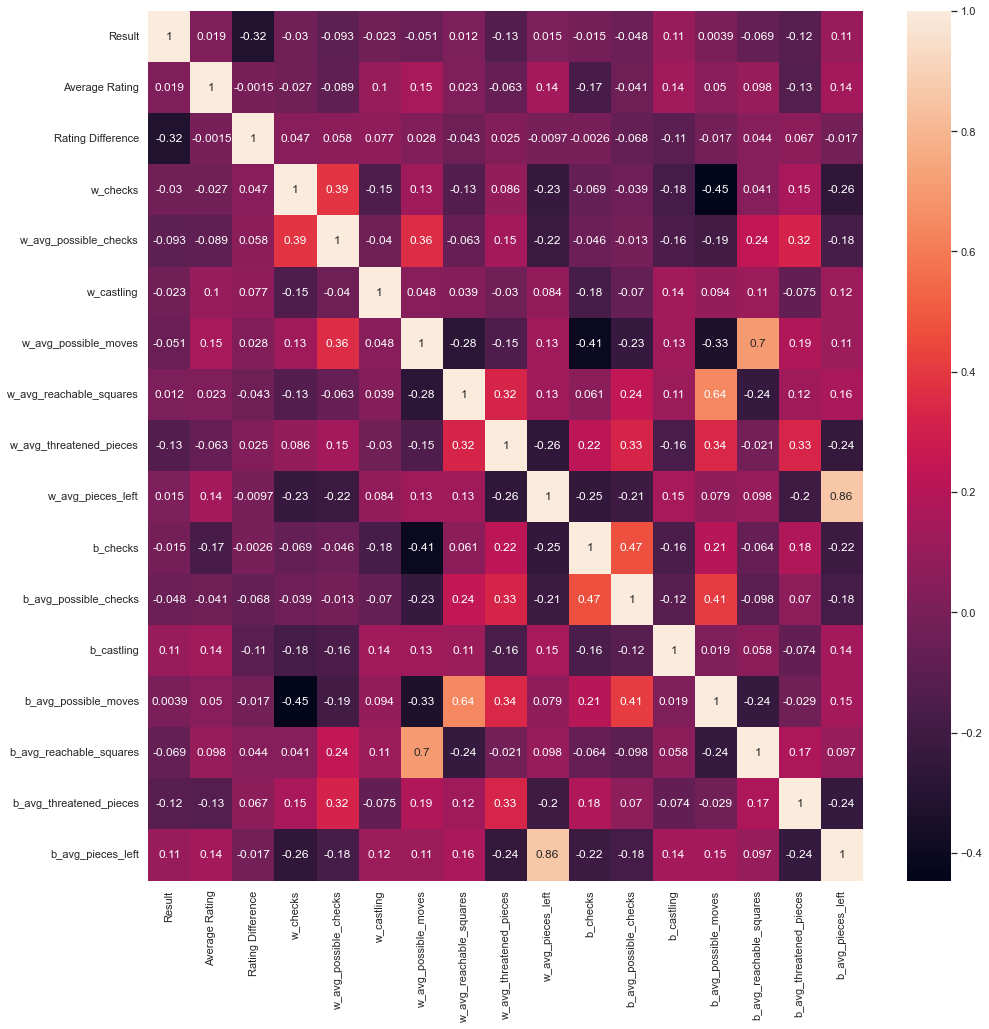

In [680]:
data_feat["Result"] = data_feat["Result"].apply(lambda x: 0 if x == 'White Wins' else 1)
corr = data_feat.corr(method='spearman')
sns.set(rc = {'figure.figsize':(16,16)})
sns.heatmap(corr,annot=True)

We can notice a few interesting correlations between some of our features, e.g.
we can see that each player's avg reachable squares highly correlated with the other player possible moves
The pieces left for each player are also highly correlated

Now we can train a model again with the new features

In [681]:
from sklearn import linear_model, metrics, preprocessing
model = linear_model.LogisticRegression(max_iter=1000)


train_data, test_data = train_test_split(data_feat, test_size=0.3)

X_train = train_data[['Average Rating', 'Rating Difference'] + new_feat_cols]
y_train = train_data['Result']

X_test = test_data[['Average Rating', 'Rating Difference'] + new_feat_cols]
y_test = test_data['Result']


scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

model.fit(X_train, y_train)

predicted = model.predict(X_test)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.68      0.85      0.76        79
           1       0.77      0.56      0.65        71

    accuracy                           0.71       150
   macro avg       0.73      0.71      0.70       150
weighted avg       0.72      0.71      0.71       150



As we can see the metrics improved by more than 4%, lets see what features are most relevant

In [682]:
importance = model.coef_[0]
# summarize feature importance
imp_dict = {train_data.drop(['PGN', 'Result'], axis=1).columns[i]:abs(v) for i,v in enumerate(importance)}
imp_df = pd.DataFrame.from_dict(imp_dict,orient='index',columns=['score'])
imp_df = imp_df.sort_values(by='score', ascending=False)
imp_df

,score
b_avg_pieces_left,0.866886
w_avg_pieces_left,0.726411
Rating Difference,0.713736
b_castling,0.170664
b_avg_possible_moves,0.144714
b_avg_reachable_squares,0.141340
w_avg_reachable_squares,0.125810
w_avg_threatened_pieces,0.124213
b_avg_threatened_pieces,0.104445
w_checks,0.100679


So it seems like avg_reachable_squares is our best feature

In [683]:
best_feat_cols = list(imp_df.index)

Lets try train the model with the best 5 features

In [684]:
best_feat = best_feat_cols[:5]

In [685]:
best_feat

['b_avg_pieces_left',
 'w_avg_pieces_left',
 'Rating Difference',
 'b_castling',
 'b_avg_possible_moves']

In [686]:
model = linear_model.LogisticRegression(max_iter=1000)


train_data, test_data = train_test_split(data_feat, test_size=0.3)

X_train = train_data[['Average Rating', 'Rating Difference'] + best_feat]
y_train = train_data['Result']

X_test = test_data[['Average Rating', 'Rating Difference'] + best_feat]
y_test = test_data['Result']


scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

model.fit(X_train, y_train)

predicted = model.predict(X_test)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.65      0.59      0.62        78
           1       0.59      0.65      0.62        72

    accuracy                           0.62       150
   macro avg       0.62      0.62      0.62       150
weighted avg       0.62      0.62      0.62       150



Ok so it seems less is better, lets stay with those 5 features

Now lets see what is the real impact of K value (number of moves)
Lets train the model with different k values

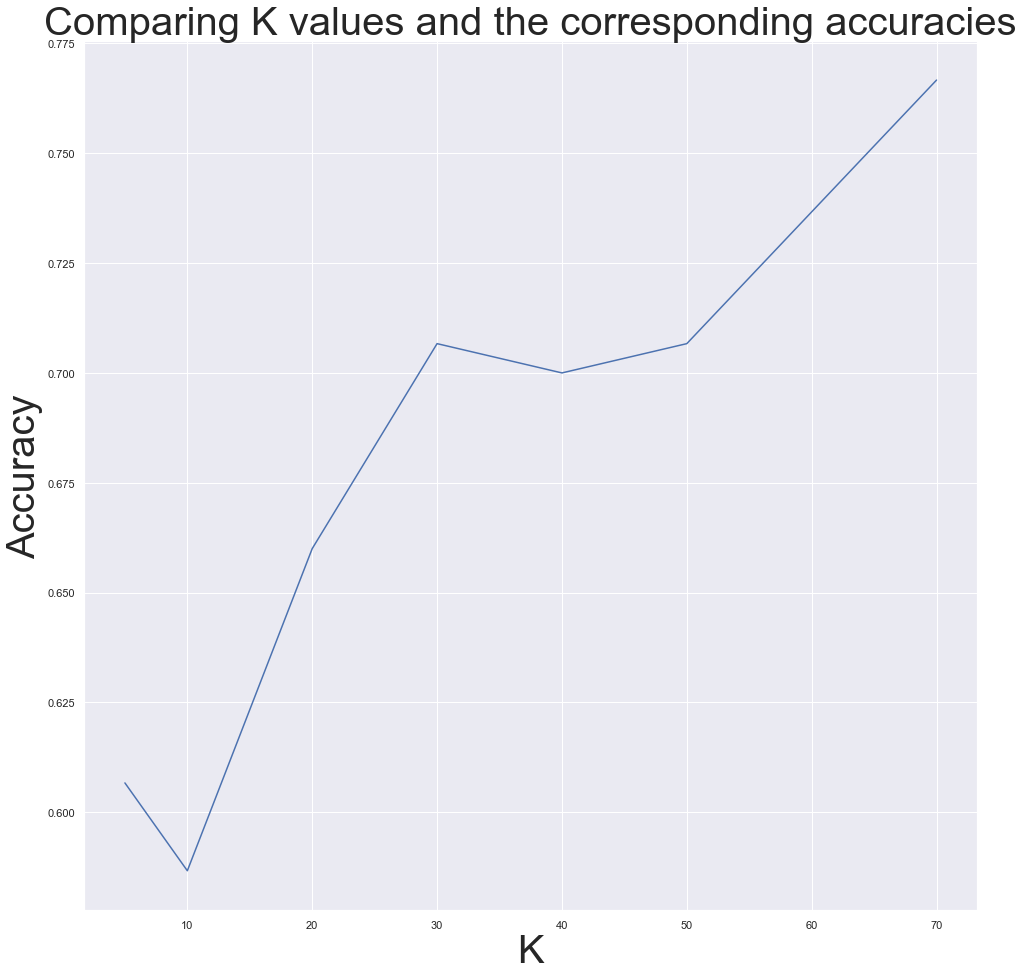

In [687]:
from sklearn import linear_model, metrics, preprocessing

acc = {}

for k in [5, 10, 20, 30, 40, 50, 70]:

    feat_df = pd.DataFrame(columns=new_feat_cols)

    for i, pgn in enumerate(data.PGN):
        game_features = extract_features(pgn, move_number=k)
        w_feat = game_features[game_features['player'] == 'White']
        b_feat = game_features[game_features['player'] == 'Black']
        # print(w_feat)
        # break
        feat_df.loc[i] = w_feat.values[0][1:].tolist() + b_feat.values[0][1:].tolist()
        if i == limit_games - 1:
            break

    data_k = data.loc[np.arange(0, limit_games)].join(feat_df)


    model = linear_model.LogisticRegression()


    train_data, test_data = train_test_split(data_k, test_size=0.3)

    X_train = train_data[['Average Rating', 'Rating Difference'] + best_feat]
    y_train = train_data['Result']

    X_test = test_data[['Average Rating', 'Rating Difference'] + best_feat]
    y_test = test_data['Result']


    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    model.fit(X_train, y_train)

    predicted = model.predict(X_test)
    c_acc = metrics.accuracy_score(y_test, predicted)
    acc[k] = c_acc
    #print(f'K={k}, {c_acc}')

plt.xlabel("K",fontsize = 40)
plt.ylabel("Accuracy",fontsize = 40)
plt.title("Comparing K values and the corresponding accuracies",fontsize = 40)

plt.plot(acc.keys(), acc.values())

So it seems like 30 is actually a good choice as it's on a local maxima in the graph also accuracy seems to improve linearly when k > 50

Now lets try Some more models

In [688]:
from sklearn.ensemble import GradientBoostingClassifier


model = GradientBoostingClassifier(n_estimators=1000, learning_rate=1.,
    max_depth=5, random_state=0).fit(X_train, y_train)


predicted = model.predict(X_test)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

  Black Wins       0.62      0.67      0.64        69
  White Wins       0.70      0.65      0.68        81

    accuracy                           0.66       150
   macro avg       0.66      0.66      0.66       150
weighted avg       0.66      0.66      0.66       150



In [689]:
from sklearn.ensemble import RandomForestClassifier


model = RandomForestClassifier(random_state=0).fit(X_train, y_train)


predicted = model.predict(X_test)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

  Black Wins       0.64      0.61      0.62        69
  White Wins       0.68      0.70      0.69        81

    accuracy                           0.66       150
   macro avg       0.66      0.66      0.66       150
weighted avg       0.66      0.66      0.66       150



## Now we want to explore a different set of features, so instead of hand engineered features, we can try a sequence model that will possibly take all game moves as a sequence and will predict the output - win / lose (for white)
## The move sequence is exactly the pgn that we have, A PGN (Portable Game Notation) is a standard plain text format for recording chess games.

# Chess s2s model

## The PGN format is a list of ordinal strings which indicate 2 moves for white and black - the location they played + their piece (or nothing for pawn) and the move(or round) index:

In [690]:
data.PGN.head(5)

0    1. e4 e5 2. Nf3 Nf6 3. d3 Bc5 4. Be2 Nc6 5. c3...
1    1. e4 e5 2. f4 exf4 3. Nf3 Nc6 4. d4 Bb4+ 5. c...
2    1. e4 e5 2. Nf3 Nc6 3. Bb5 Nd4 4. Nxe5 Nxb5 5....
3    1. e4 d5 2. Nc3 d4 3. Nd5 e5 4. Nf3 f5 5. Nxe5...
4    1. d4 a6 2. e4 e6 3. e5 c5 4. c3 cxd4 5. Qxd4 ...
Name: PGN, dtype: object

PGN format: index. piece+board_loc_for_white_piece+board_loc_for_black

# So our sequence model receives this PGN for each game and predicts the result, the length of the sequence or the number of moves can be set with k parameter the model is based on a simple lstm model
# The first layer is the encoding layer to encode the move strings
# Then, another layer that that takes the lstm output and produces the final output layer with 2 outputs - white win / lose
# Please see "chess_s2s_model/model.py" for model architecture and code

Now Lets train the model on the pgn's and print the results - for this demo purpose we will run the training for only 3 epochs

loading train data..


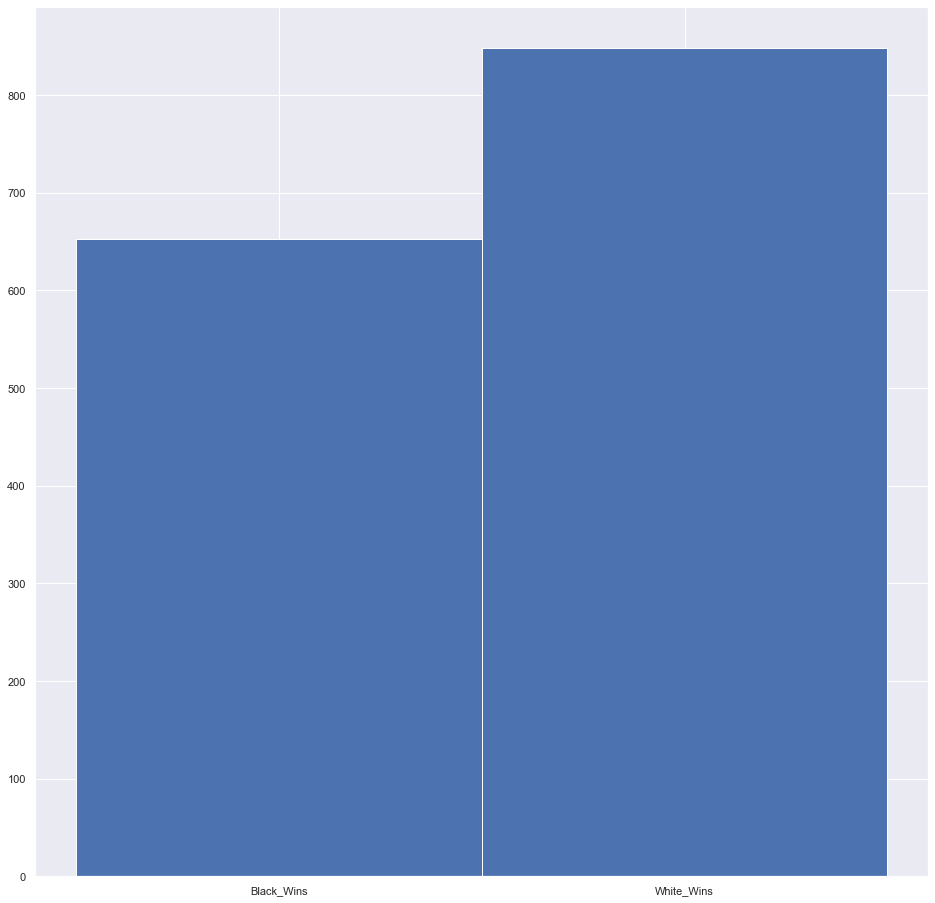

start train (train size:1188:
)
Iter: 0, Train loss: 0.6855926518187379, Validation loss: 0.686847471127205
Train accuracy: 0.5555555555555556, Validation accuracy: 0.5555555555555556


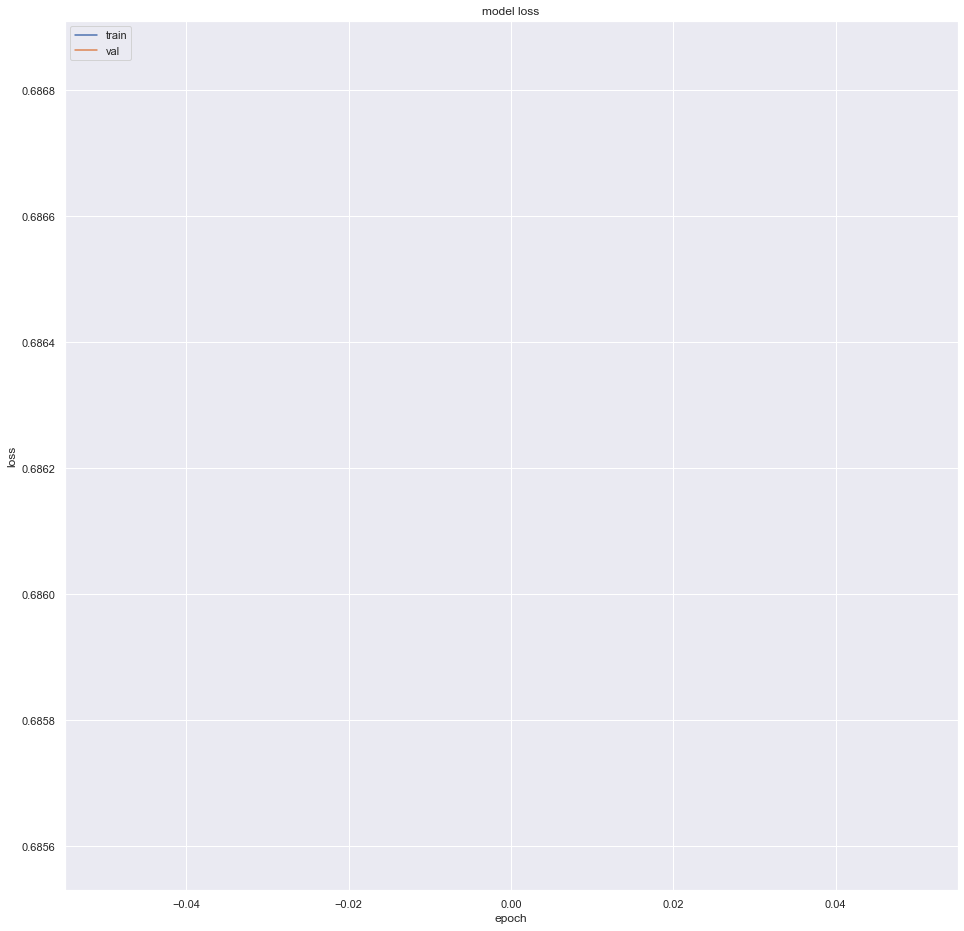

Iter: 1, Train loss: 0.6764110915287577, Validation loss: 0.685370612826813
Train accuracy: 0.57996632996633, Validation accuracy: 0.5555555555555556


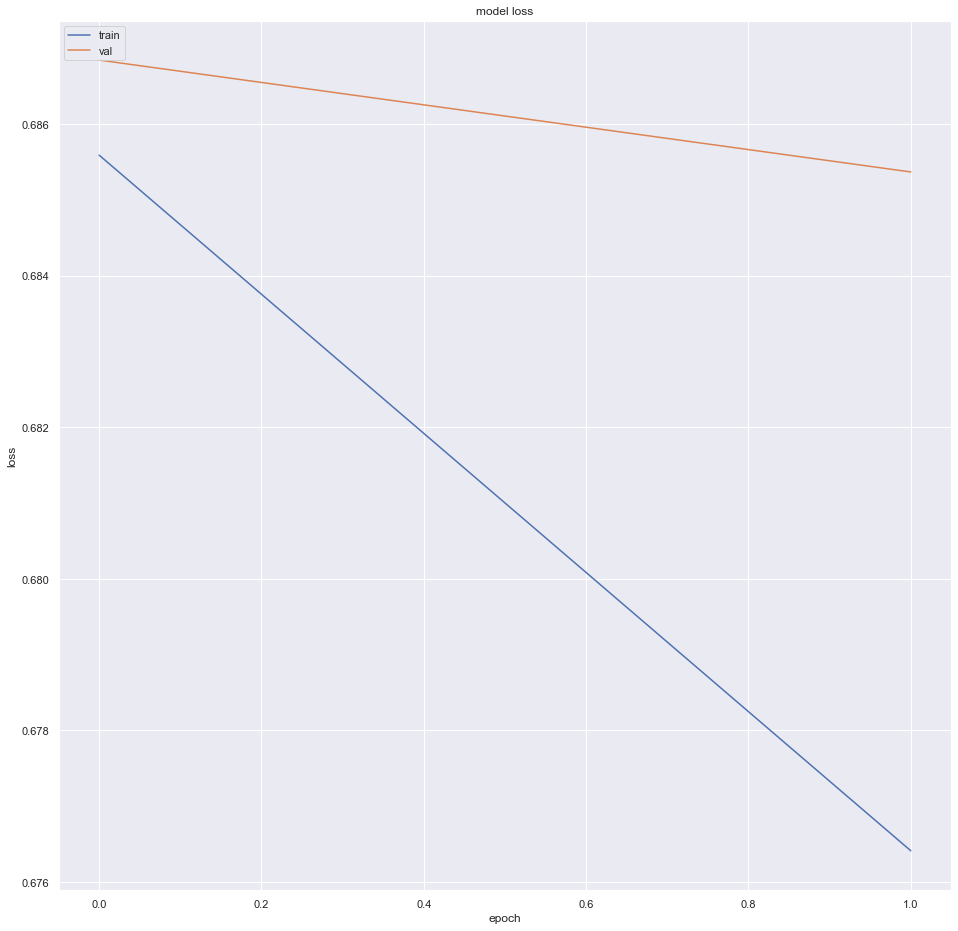

Iter: 2, Train loss: 0.6672455468763807, Validation loss: 0.6841637028588189
Train accuracy: 0.585016835016835, Validation accuracy: 0.5454545454545454


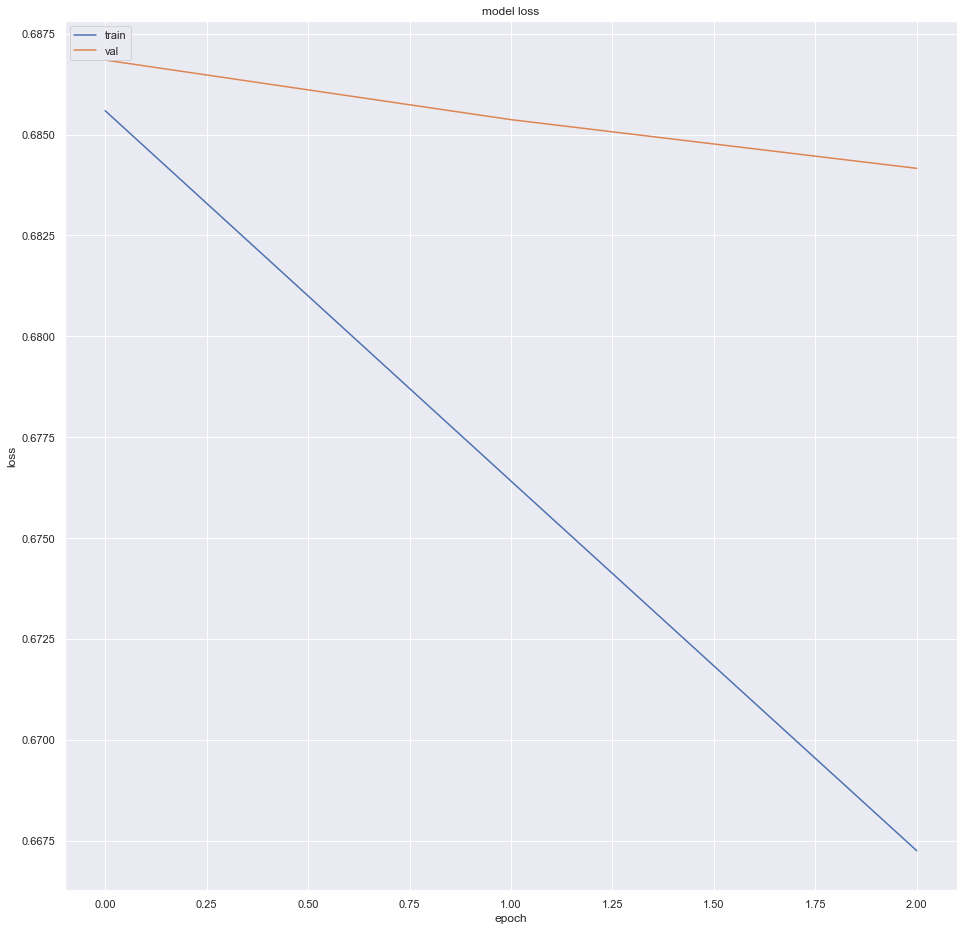

Final test accuracy: 0.46666666865348816
(0.23333333333333334, 0.5, 0.3181818181818182, None)


/Users/guyhaimovitz/PycharmProjects/chess/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [691]:
from chess_s2s_model.train import train

k = 20 # Max number of moves
epochs = 3 # For notebook demo run
games_limit=1500
train(games_limit=games_limit, lr=0.01, epochs=epochs, k=k, save_model=False, plot=True)

The best model was trained with the following parameters:

lr = 0.01 - learning rate
games_limit=15000 - limiting to 15k games (before removing draw and non-classic games)
epochs=125 - number of epochs
embedding_dim=128 - embedding dim
h1_dim=64 - h1 dim (one layer after the embedding)
h2_dim=128 - h2 dim (one layer after h1)
k=20 - max number of moves in each game
replace = True - replace moves that occur in less than 1% of the data


Now we'll load our best trained model and evaluate

In [692]:
from chess_s2s_model.model import LSTMTagger
import torch
from chess_s2s_model import data
from sklearn.metrics import precision_recall_fscore_support


with open('test_data.csv', 'rb') as file:
    test_data = pickle.load(file)

with open('word_to_ix', 'rb') as file:
    word_to_ix = pickle.load(file)

with open('tag_to_ix', 'rb') as file:
    tag_to_ix = pickle.load(file)


embedding_dim = 128
h1_dim = 64
h2_dim = 128
model = LSTMTagger(embedding_dim, h1_dim, h2_dim, len(word_to_ix), len(tag_to_ix))
model.load_state_dict(torch.load('chess_model'))
model.eval()

 # See what the scores are after training
with torch.no_grad():
    y_true = []
    y_pred = []
    for sentence, tags in test_data:
        inputs = data.prepare_sequence(sentence, word_to_ix)
        tag_scores = model(inputs)
        y_pred.append(np.argmax(tag_scores[-1].reshape(1, -1)))
        y_true.append(tag_to_ix[tags])

    print(f'Final test accuracy: {sum(y_t == y_p for y_t, y_p in zip(y_true, y_pred)) / len(y_true)}')
    print(precision_recall_fscore_support(y_true, y_pred, average='macro'))

Final test accuracy: 0.9399999976158142
(0.9394722766981636, 0.9401785714285714, 0.9397832195905259, None)


## We can see that the lstm based model preforms alot better than the previous ones - 93% vs 67% accuracy